In [152]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize
import matplotlib
from PIL import Image 
import matplotlib.image

In [206]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [207]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

In [4]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [5]:
y[1000], y_onehot[1000,:]

(array([2], dtype=uint8), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

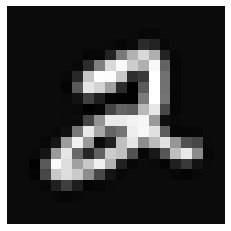

In [6]:
test_one=X[1000,:]
test_one = test_one.reshape(20,20)
test_one = test_one.T 
plt.imshow(test_one,cmap='gray')
plt.axis('off')  # 关掉坐标轴
plt.show()

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [8]:
def forward_propagation(X,theta1,theta2):
    m=X.shape[0]
    a1=np.insert(X,0,values=np.ones(m),axis=1)
    z2=a1*theta1.T
    a2=np.insert(sigmoid(z2),0,values=np.ones(m),axis=1)
    z3=a2*theta2.T
    h=sigmoid(z3)
    return a1, z2, a2, z3, h
    

In [9]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

In [10]:
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

params.shape

(10285,)

In [11]:
params[:hidden_size * (input_size + 1)].shape

(10025,)

In [12]:
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta1

matrix([[ 0.12148614, -0.04410064,  0.11042166, ...,  0.10304461,
         -0.08779675,  0.10525147],
        [-0.04363043,  0.00826556,  0.11487236, ..., -0.11633708,
          0.1050732 , -0.04678448],
        [ 0.10674993, -0.10910434, -0.08939668, ...,  0.10022922,
          0.00713996, -0.07281345],
        ...,
        [-0.08705319, -0.08002304, -0.0175064 , ...,  0.05816887,
         -0.10632292,  0.0408212 ],
        [-0.07806692, -0.06881166, -0.08333705, ..., -0.10651798,
         -0.01554995,  0.00095527],
        [ 0.1045877 , -0.05729581,  0.09017467, ...,  0.11453294,
          0.03040857,  0.02044361]])

In [13]:
x=((hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) )
x

10285

In [14]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagation(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [15]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

7.093349787806881

In [16]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [17]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagation(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad,delta1,delta2

In [18]:
J, grad,delta1,delta2 = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
grad

array([ 1.64664421e-02, -8.82012852e-06,  2.20843312e-05, ...,
        2.00922027e-01,  2.21264392e-01,  2.28647329e-01])

In [19]:
fmin=minimize(fun=backprop,x0=params,args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
              method='TNC',jac=True,options={'maxiter':400})
fmin

     fun: 0.314690657963394
     jac: array([ 1.68713874e-04, -1.50914434e-08,  2.39976989e-08, ...,
       -3.13678207e-06,  2.23496898e-05, -2.57685518e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 28
  status: 3
 success: False
       x: array([-6.00804066e-01, -7.54572168e-05,  1.19988495e-04, ...,
       -1.53269989e+00,  2.79336283e+00, -6.18430064e-01])

In [20]:
def backprop1(params, input_size, hidden_size, num_labels, X, y, learning_rate,theta1,theta2):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagation(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad,delta1,delta2

In [238]:
# fmin=minimize(fun=backprop,x0=params,args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
#               method='TNC',jac=True)
# 如果不限定次数的话运行时间过久

In [22]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagation(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [226]:
with open('E:\Python\ML\\theta1.txt', 'w') as f:
     for i in range (len (theta1)): 
         f.write(str(theta1[i])+'\n')

In [227]:
with open('E:\Python\ML\\theta2.txt', 'w') as f:
     for i in range (len (theta2)): 
         f.write(str(theta2[i])+'\n')

In [197]:
predictPhoto=X[600,:]
a1, z2, a2, z3, h1 = forward_propagation(predictPhoto, theta1, theta2)
y_pred = np.array(np.argmax(h1, axis=1) + 1)
y_pred

array([[1]], dtype=int64)

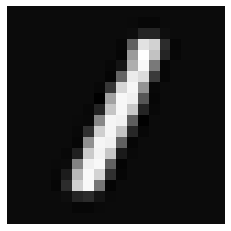

In [190]:
predictPhoto = predictPhoto.reshape(20,20)
predictPhoto = predictPhoto.T 
plt.imshow(predictPhoto,cmap='gray')
plt.axis('off')  # 关掉坐标轴
plt.show()

In [158]:
def ImageToMatrix(filename):
    # 读取图片
    im = Image.open(filename)
    # 显示图片
    im.show()  
    width,height = im.size
    im = im.convert("L") 
    data = im.getdata()
    data = np.matrix(data,dtype='float')/255.0
    #new_data = np.reshape(data,(width,height))
    new_data = np.reshape(data,(height,width))
    return new_data

In [122]:
correct=[1 if a==b else 0 for (a,b) in zip(y_pred,y)]
accuracy=(sum(map(int,correct)))/float(len(correct))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.5%


In [25]:
fmin.x.shape

(10285,)

In [26]:
delta1.shape

(25, 401)

In [253]:
def cost1(params, input_size, hidden_size, num_labels, X, y, learning_rate,theta1,theta2):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagation(X, theta3, theta4)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [29]:
theta1.shape

(25, 401)

In [115]:
def gradientChecking(theta1,theta2,X,y_onehot,delta1,delta2,params,input_size,hidden_size,num_labels,learning_rate):
    m1,n1=theta1.shape
    m2,n2=theta2.shape
    eps=0.0001
    f_theta1=np.zeros((m1,n1))
    f_theta2=np.zeros((m2,n2))
    for i in range(m1):
        for j in range(n1):
            theta_plus=theta1.copy()
            theta_plus[i,j]=theta_plus[i,j]+eps
            theta_minus=theta1.copy()
            theta_minus[i,j]=theta_minus[i,j]-eps
            f_theta1[i,j]=(cost1(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate,theta_plus,theta2)
                           -cost1(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate,theta_minus,theta2))/(2*eps)- delta1[i,j]
    
    for i in range(m2):
        for j in range(n2):
            theta_plus=theta2.copy()
            theta_plus[i,j]=theta_plus[i,j]+eps
            theta_minus=theta2.copy()
            theta_minus[i,j]=theta_minus[i,j]-eps
            f_theta2[i,j]=(cost1(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate,theta1,theta_plus)
                           -cost1(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate,theta1,theta_minus))/(2*eps)- delta2[i,j]
            
    return f_theta1,f_theta2


In [116]:
f1,f2 = gradientChecking(theta1,theta2,X,y_onehot,delta1,delta2,params,input_size,hidden_size,num_labels,learning_rate)

In [117]:
np.max(f1),np.max(f2),np.min(f1),np.min(f2)

(8.229378604344278e-12,
 7.586737820108522e-12,
 -7.0954801685866806e-12,
 -3.932381330284951e-12)

In [120]:
f1

array([[ 1.82792469e-12, -9.57754778e-14,  4.92884206e-14, ...,
        -7.12975855e-14, -1.03415432e-14,  9.54421459e-14],
       [ 5.01880373e-12, -2.48025159e-14,  4.78305812e-14, ...,
         1.00383636e-13, -2.46432385e-13, -1.77800753e-13],
       [ 4.55497897e-13,  1.64267075e-13,  2.43410644e-13, ...,
        -3.95599955e-14, -2.28430530e-14,  1.06327536e-13],
       ...,
       [-1.67439836e-12,  1.92341087e-14,  1.15609165e-13, ...,
        -1.49440967e-14,  1.49901021e-13, -9.56254659e-15],
       [ 2.95825759e-12, -1.25143682e-13,  2.15852863e-14, ...,
        -4.26609851e-14, -8.76668681e-14,  8.06534515e-14],
       [-7.08142583e-15,  2.08263247e-13,  1.33137751e-13, ...,
        -1.74814839e-13, -2.41043150e-13, -1.02864347e-13]])

In [130]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))
theta=serialize(theta1,theta2)

In [131]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [138]:
def plot_hidden_layer(theta):
    """
    theta: (10285, )
    """
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

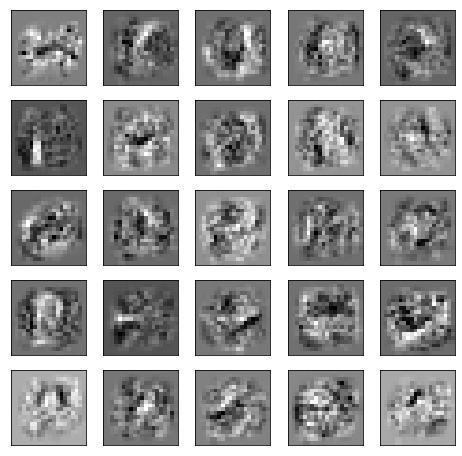

In [139]:
plot_hidden_layer(theta)
plt.show()

将原数据集6:2:2分割称训练集，交叉验证集，测试集。使用训练集拟合参数，分别用验证集和测试集测验该模型的泛化能力

In [213]:
np.random.shuffle(X)

In [218]:
train_set=X[0:3000,:]
cv_set=X[3000:4000,:]
test_set=X[4000:,:]
train_set.shape,cv_set.shape,test_set.shape

((3000, 400), (1000, 400), (1000, 400))

In [229]:
a1, z2, a2, z3, h = forward_propagation(train_set, theta1, theta2)
y_train = np.array(np.argmax(h, axis=1) + 1)
y_train

array([[7],
       [6],
       [5],
       ...,
       [5],
       [2],
       [1]], dtype=int64)

In [232]:
_, _, _, _, h = forward_propagation(cv_set, theta1, theta2)
y_cv = np.array(np.argmax(h, axis=1) + 1)
y_cv.shape

(1000, 1)

In [233]:
_, _, _, _, h = forward_propagation(test_set, theta1, theta2)
y_test = np.array(np.argmax(h, axis=1) + 1)
y_test.shape

(1000, 1)

In [235]:
encoder1 = OneHotEncoder(sparse=False)
y_onehot1 = encoder1.fit_transform(y_train)
encoder2 = OneHotEncoder(sparse=False)
y_onehot2 = encoder2.fit_transform(y_cv)
encoder3 = OneHotEncoder(sparse=False)
y_onehot3 = encoder3.fit_transform(y_test)

In [237]:
J, grad,delta1,delta2 = backprop(params, input_size, hidden_size, num_labels, train_set, y_onehot1, learning_rate)
grad

array([ 1.64767232e-02, -1.47002142e-05,  3.68072187e-05, ...,
        2.00509407e-01,  2.21942361e-01,  2.29278602e-01])

In [239]:
train_min=minimize(fun=backprop,x0=params,args=(input_size, hidden_size, num_labels, train_set, y_onehot1, learning_rate),
                  method='TNC',jac=True,options={'maxiter':400})
train_min

     fun: 0.36268603465059734
     jac: array([-1.10566511e-04, -2.14784836e-08,  2.73774627e-08, ...,
       -1.55638739e-07, -1.33910039e-05,  9.95857150e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 401
     nit: 26
  status: 3
 success: False
       x: array([-1.96508626e+00, -6.44354507e-05,  8.21323881e-05, ...,
       -9.74412091e-01,  1.23200180e+00,  3.46039397e-01])

In [240]:
train_min.x.shape

(10285,)

In [274]:
theta3 = np.matrix(np.reshape(train_min.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta4 = np.matrix(np.reshape(train_min.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

In [275]:
_, _, _, _, h = forward_propagation(train_set, theta3, theta4)
y_pred1 = np.array(np.argmax(h, axis=1) + 1)
y_pred1

array([[7],
       [6],
       [5],
       ...,
       [5],
       [2],
       [1]], dtype=int64)

In [276]:
correct1=[1 if a==b else 0 for (a,b) in zip(y_pred1,y_train)]
accuracy_train=(sum(map(int,correct1)))/float(len(correct1))
print('accuracy_train:{}%'.format(accuracy_train*100))

accuracy_train:99.86666666666667%


In [269]:
_, _, _, _, h = forward_propagation(cv_set, theta3, theta4)
y_pred2 = np.array(np.argmax(h, axis=1) + 1)
y_pred2.shape

(1000, 1)

In [277]:
correct2=[1 if a==b else 0 for (a,b) in zip(y_pred2,y_cv)]
accuracy_cv=(sum(map(int,correct2)))/float(len(correct2))
print('accuracy_cv:{}%'.format(accuracy_cv*100))

accuracy_cv:95.1%


In [285]:
_, _, _, _, h = forward_propagation(test_set, theta3, theta4)
y_pred3 = np.array(np.argmax(h, axis=1) + 1)


In [286]:
correct3=[1 if a==b else 0 for (a,b) in zip(y_pred3,y_test)]
accuracy_test=(sum(map(int,correct3)))/float(len(correct3))
print('accuracy_test:{}%'.format(accuracy_test*100))

accuracy_test:94.6%


#总结：该模型训练集准确率高（99.86%），其在cv_set,test_set上泛化能力尚可，准确率达到了95.1%和94.6%